###  Vanilla Autoencoder

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import torch

In [2]:
batch_size = 128

MNIST DATASET

In [3]:
# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


MODEL

In [4]:
# Hyperparameters
learning_rate = 0.005
num_epochs = 5

# Architecture
num_features = 784
num_hidden_1 = 32

# Other
random_seed = 123

In [5]:
class Autoencoder(torch.nn.Module):    
    def __init__(self, num_features, num_hidden_1):
        super(Autoencoder, self).__init__()
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
    
    def encode(self, x):
        x = F.leaky_relu(self.linear_1(x))
        return x
         
    def decode(self, x):
        x = F.sigmoid(self.linear_2(x))
        return x
        
    def forward(self, x):
        encoded = encode(x)
        decoded = decode(encoded)
        return decoded

In [6]:
torch.manual_seed(random_seed)

# Instantiate Autoencoder model
model_ = Autoencoder(num_features=num_features, num_hidden_1=num_hidden_1)    

cost_fn_2 = torch.nn.BCELoss() # torch.nn.MSELoss()
optimizer_2 = torch.optim.Adam(model_.parameters(), lr=learning_rate)

In [7]:
save_cost =[]
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28)

        if torch.cuda.is_available():
            features, targets = features.cuda(), targets.cuda()
            
        ### FORWARD AND BACK PROP
        optimizer_2.zero_grad()
        
        encoded = model_.encode(features)
        decoded_2 = model_.decode(encoded)
        
        cost = cost_fn_2(decoded_2, features)        
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer_2.step()
        
        ### LOGGING
        if not batch_idx % 50:
            
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost.item()))        
        save_cost.append(cost.item())

Epoch: 001/005 | Batch 000/468 | Cost: 0.6985
Epoch: 001/005 | Batch 050/468 | Cost: 0.2415
Epoch: 001/005 | Batch 100/468 | Cost: 0.1905
Epoch: 001/005 | Batch 150/468 | Cost: 0.1571
Epoch: 001/005 | Batch 200/468 | Cost: 0.1428
Epoch: 001/005 | Batch 250/468 | Cost: 0.1344
Epoch: 001/005 | Batch 300/468 | Cost: 0.1265
Epoch: 001/005 | Batch 350/468 | Cost: 0.1248
Epoch: 001/005 | Batch 400/468 | Cost: 0.1224
Epoch: 001/005 | Batch 450/468 | Cost: 0.1125
Epoch: 002/005 | Batch 000/468 | Cost: 0.1171
Epoch: 002/005 | Batch 050/468 | Cost: 0.1121
Epoch: 002/005 | Batch 100/468 | Cost: 0.0998
Epoch: 002/005 | Batch 150/468 | Cost: 0.1024
Epoch: 002/005 | Batch 200/468 | Cost: 0.1046
Epoch: 002/005 | Batch 250/468 | Cost: 0.1039
Epoch: 002/005 | Batch 300/468 | Cost: 0.1033
Epoch: 002/005 | Batch 350/468 | Cost: 0.1051
Epoch: 002/005 | Batch 400/468 | Cost: 0.1000
Epoch: 002/005 | Batch 450/468 | Cost: 0.0992
Epoch: 003/005 | Batch 000/468 | Cost: 0.0965
Epoch: 003/005 | Batch 050/468 | C

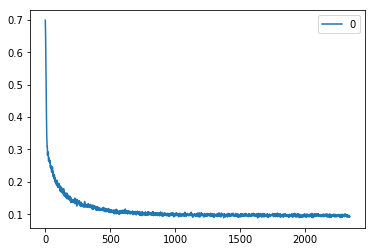

In [8]:
pd.DataFrame(save_cost).plot()

Check images

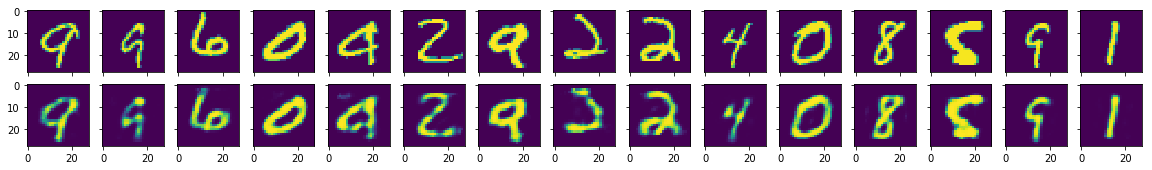

In [9]:
n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features.data.numpy()[:n_images]
decoded_images = decoded_2.data.numpy()[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].imshow(img[i].reshape((image_width, image_width)))

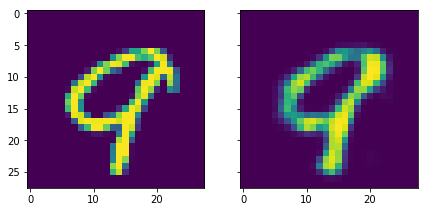

In [10]:
n_images = 1
image_width = 28
index=0

fig, axes = plt.subplots(nrows=1, ncols=2, 
                         sharex=True, sharey=True, figsize=(7, 7))
orig_images = features.data.numpy()[:n_images]
decoded_images = model_.decode(model_.encode(features)).data.numpy()[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax.imshow(img[i].reshape((image_width, image_width)))

#### Look how decoder reduced dimensionality from 784 to 32

In [11]:
features.size()

torch.Size([96, 784])

In [12]:
model_.encode(features).size()

torch.Size([96, 32])

### Denoising Autoencoder on noisy images

Example of  noisy image

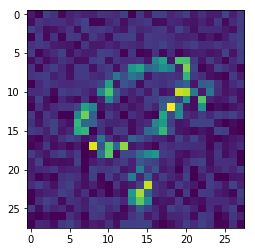

In [13]:
noise_ = torch.rand(features.size(0),28*28)
example = torch.mul(features.data+0.25,noise_)
plt.imshow(example[0].numpy().reshape((image_width, image_width)))

In [14]:
# Hyperparameters
learning_rate = 0.0001
num_epochs = 10

# Architecture
num_features = 784
num_hidden_1 = 32

# Other
random_seed = 123

In [15]:
torch.manual_seed(random_seed)

# Instantiate encoder and decoder models
model_noisy = Autoencoder(num_features=num_features, num_hidden_1=num_hidden_1)    

cost_fn_noisy = torch.nn.BCELoss() # torch.nn.MSELoss()
optimizer_noisy = torch.optim.RMSprop(model_noisy.parameters(), lr=learning_rate, momentum=0.9)

In [16]:
save_cost =[]
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28)

        # Add noise to the features
        noise = torch.rand(features.size(0),28*28)
        features = torch.mul(features.data+0.25,noise)
        features = Variable(features)
        
        if torch.cuda.is_available():
            features, targets = features.cuda(), targets.cuda()
            
        ### FORWARD AND BACK PROP
        optimizer_noisy.zero_grad()
        
        encoded_noisy = model_noisy.encode(features)
        decoded_noisy = model_noisy.decode(encoded_noisy)
        
        cost = cost_fn_noisy(decoded_noisy, features)        
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer_noisy.step()
        
        ### LOGGING
        if not batch_idx % 50:
            
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost.item()))        
        save_cost.append(cost.item())

Epoch: 001/010 | Batch 000/468 | Cost: 0.6978
Epoch: 001/010 | Batch 050/468 | Cost: 0.4679
Epoch: 001/010 | Batch 100/468 | Cost: 0.4631
Epoch: 001/010 | Batch 150/468 | Cost: 0.4580
Epoch: 001/010 | Batch 200/468 | Cost: 0.4554
Epoch: 001/010 | Batch 250/468 | Cost: 0.4576
Epoch: 001/010 | Batch 300/468 | Cost: 0.4533
Epoch: 001/010 | Batch 350/468 | Cost: 0.4532
Epoch: 001/010 | Batch 400/468 | Cost: 0.4521
Epoch: 001/010 | Batch 450/468 | Cost: 0.4465
Epoch: 002/010 | Batch 000/468 | Cost: 0.4484
Epoch: 002/010 | Batch 050/468 | Cost: 0.4472
Epoch: 002/010 | Batch 100/468 | Cost: 0.4442
Epoch: 002/010 | Batch 150/468 | Cost: 0.4468
Epoch: 002/010 | Batch 200/468 | Cost: 0.4432
Epoch: 002/010 | Batch 250/468 | Cost: 0.4428
Epoch: 002/010 | Batch 300/468 | Cost: 0.4444
Epoch: 002/010 | Batch 350/468 | Cost: 0.4453
Epoch: 002/010 | Batch 400/468 | Cost: 0.4417
Epoch: 002/010 | Batch 450/468 | Cost: 0.4432
Epoch: 003/010 | Batch 000/468 | Cost: 0.4433
Epoch: 003/010 | Batch 050/468 | C

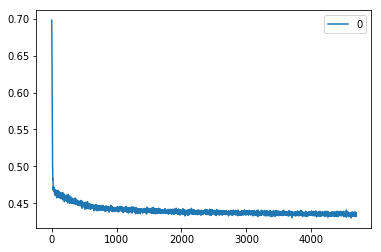

In [17]:
pd.DataFrame(save_cost).plot()

Check images

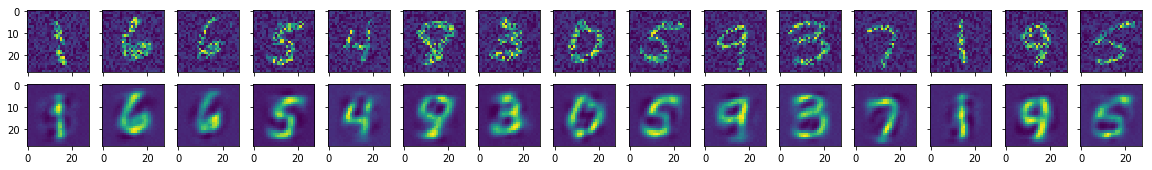

In [18]:
n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features.data.numpy()[:n_images]
decoded_images = decoded_noisy.data.numpy()[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].imshow(img[i].reshape((image_width, image_width)))

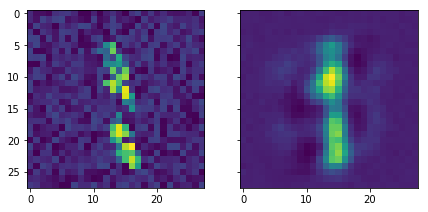

In [19]:
n_images = 1
image_width = 28

fig, axes = plt.subplots(nrows=1, ncols=2, 
                         sharex=True, sharey=True, figsize=(7, 7))
orig_images = features.data.numpy()[:n_images]
noisy_images = decoded_noisy.data.numpy()[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, noisy_images]):
        ax.imshow(img[i].reshape((image_width, image_width)))